In [23]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
from keras.models import load_model
from keras import backend as K
import numpy as np
import os
import sys
import random
import time
import matplotlib.pyplot as plt
import seaborn as sns
from vivit import run_experiment, test_files, classes
from data import get_video_label, VideoDataGenerator, labels_df, files, labels, num_to_label
from synthetic import *
import scipy.stats as stats
from sklearn.model_selection import train_test_split
import numpy as np
import keras
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd

In [9]:
basic = keras.models.load_model('model-basic.keras');
high_lr = keras.models.load_model('model-high-lr.keras');

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/layer.py:357: UserWarning: `build()` was called on layer 'tubelet_embedding_2', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/saving/saving_lib.py:355: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 137 variables whereas the saved optimizer has 272 variables. 
  trackable.load_own_variables(weights_store.get(inner_path))
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/layer.py:357: UserWarning: `build()` was called on layer 'tubelet_embedding_1', however the layer does not have a 

In [10]:
classes = list(labels_df.groupby('label').size().sort_values(ascending=False)[:10].index)
test_files = [f for f in files if labels[int(os.path.basename(f).split('.')[0])] in classes]
base = "../data/videos"
all_files = test_files
for folder in ["rotated", "flipped", "noised", "high_noised"]:
    all_files += [f"{base}/{folder}/{file}" for file in os.listdir(f"{base}/{folder}")]
y = [get_video_label(file) for file in all_files]

train_files, val_files, y_train, y_test = train_test_split(test_files, y, test_size=0.2, stratify=y, random_state=42)
train, validation = VideoDataGenerator(train_files), VideoDataGenerator(val_files)
full = VideoDataGenerator(all_files)

In [19]:
y_hat = basic.predict(validation)
y_hat = [num_to_label[np.argmax(y)] for y in y_hat]
y = [num_to_label[y] for y in y_test]

9/9 ━━━━━━━━━━━━━━━━━━━━ 6s 564ms/step


In [46]:
# confusion matrix
transformation = [f.split('/')[-2] for f in val_files]
preds = pd.DataFrame({'true': y, 'predicted': y_hat, 'transformation': transformation})
preds["right"] = preds['true'] == preds['predicted']
preds = preds.groupby("true").mean()

/var/folders/0s/3__sj1dn5hlcs4lg9h5cfgzh0000gn/T/ipykernel_6474/2411155364.py:5: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  preds = preds.groupby("true").mean()


In [48]:
preds

,right
true,
before,0.230769
book,0.775000
candy,0.000000
chair,0.423077
clothes,0.640000
computer,0.300000
deaf,0.130435
drink,0.600000
go,0.461538


Text(0.5, 1.0, 'Number of videos per class')

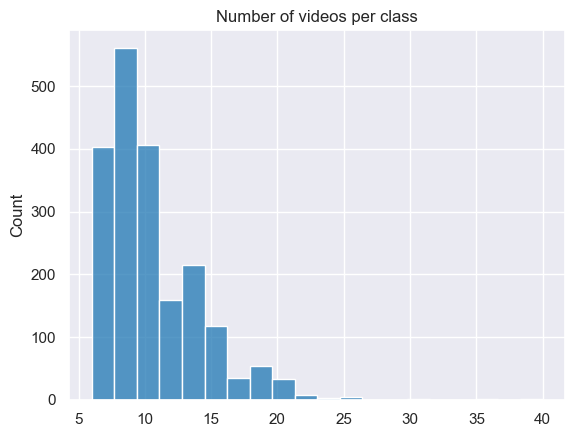

In [44]:
count = labels_df.groupby('label').size()
sns.set(style="darkgrid", palette="tab10")
sns.histplot(x=count, bins=20)
plt.title("Number of videos per class")